Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

In [ ]:
#Connect to google drive to get an access to the dataset
#from google.colab import drive
#drive.mount('/content/gdrive', force_remount=True)

Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

#Suppress tensorflow warnings. Only log the errors
import logging
tf.get_logger().setLevel(logging.ERROR)
import multiprocessing as mp

from multiprocessing.pool import ThreadPool as Pool

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  2


In [3]:
#unzip the dataset
#!unzip /content/gdrive/MyDrive/Colab_notebooks/Melanoma_detection/CNN_assignment.zip -d /content/gdrive/MyDrive/Colab_notebooks/Melanoma_detection/CNN_assignment/

In [4]:
!pip install opencv-python

### Important Note :
To run this notebook, please ensure the directory structure as follows : [Paths are relative to the current notebbok]

1. Train : data/SkinCancerISIC/Train
2. Test :  data/SkinCancerISIC/Test
3. augment : data/SkinCancerISIC/augemnt [exact copy of Train data, this is to ensure the same results even after multiple runs]

In [5]:
# Defining the path for train and test images
data_dir_train = pathlib.Path('D:\\datasets\\MelanomaSkinCancer_ISIC\\Train')
data_dir_test = pathlib.Path('D:\\datasets\\MelanomaSkinCancer_ISIC\\Test')

In [6]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print("Images available in train dataset:", image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print("Images available in test dataset:", image_count_test)

Images available in train dataset: 2239
Images available in test dataset: 118


In [7]:
#considering some predefined inputs from the assignment
batch_size = 32
img_height = 180
img_width = 180
seed_val = 123

### Load using keras.preprocessing

Use 80% of the images for training, and 20% for validation.

In [8]:
# Loading the training data
# using seed=123 while creating dataset using tf.keras.preprocessing.image_dataset_from_directory
# resizing images to the size img_height*img_width, while writing the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                               seed=seed_val,
                                                               validation_split=0.2,
                                                               image_size=(img_height,img_width),
                                                               batch_size=batch_size,
                                                               color_mode='rgb',
                                                               subset='training')

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [9]:
# Loading the validation data
# using seed=123 while creating dataset using tf.keras.preprocessing.image_dataset_from_directory
# resizing images to the size img_height*img_width, while writing the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                             seed=seed_val,
                                                             validation_split=0.2,
                                                             image_size=(img_height,img_width),
                                                             batch_size=batch_size,
                                                             color_mode='rgb',
                                                             subset='validation')

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [10]:
# List out all the classes of skin cancer and store them in a list. 
class_names = train_ds.class_names
print("The different types of cancer classes are: ")
print(class_names)

The different types of cancer classes are: 
['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Visualize one instance of all the nine classes present in the dataset

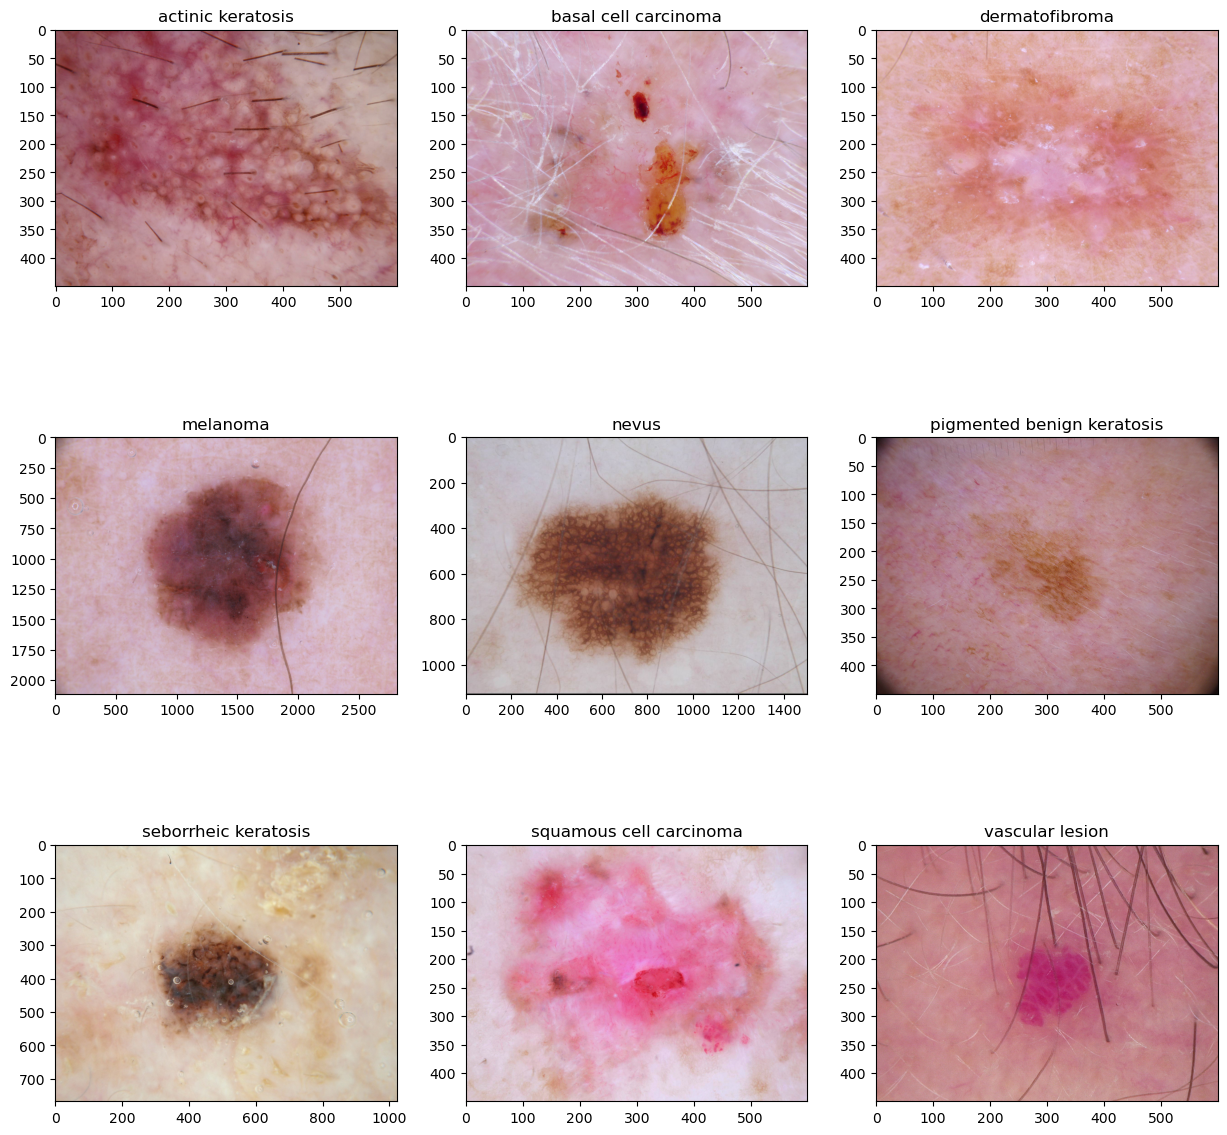

In [11]:
### visualize one instance of all the nine classes present in the dataset
plt.figure(figsize=(15,15))
for i in range(len(class_names)):
    plt.subplot(3,3,i+1)
    image= plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[0]))
    plt.title(class_names[i])
    plt.imshow(image)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the first model
#### Creating a CNN model, which can accurately detect 9 classes present in the dataset. Using ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. 

In [13]:
# CNN Model - Initial
model=models.Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(img_height,img_width,3)))

# Convolution layer with 32 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(32,(3,3),padding='same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding='same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding='same',activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))

model.add(layers.Dense(64,activation='relu'))

model.add(layers.Dense(len(class_names),activation='softmax'))

In [14]:
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 128)       7

In [15]:
# Training the model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 5s 21ms/step - loss: 1.9942 - accuracy: 0.2556 - val_loss: 1.6999 - val_accuracy: 0.3960
Epoch 2/20
56/56 [==============================] - 1s 13ms/step - loss: 1.6397 - accuracy: 0.4046 - val_loss: 1.6473 - val_accuracy: 0.4318
Epoch 3/20
56/56 [==============================] - 1s 13ms/step - loss: 1.4289 - accuracy: 0.5117 - val_loss: 1.4350 - val_accuracy: 0.4899
Epoch 4/20
56/56 [==============================] - 1s 13ms/step - loss: 1.3318 - accuracy: 0.5324 - val_loss: 1.5183 - val_accuracy: 0.4653
Epoch 5/20
56/56 [==============================] - 1s 13ms/step - loss: 1.2966 - accuracy: 0.5379 - val_loss: 1.4261 - val_accuracy: 0.5213
Epoch 6/20
56/56 [==============================] - 1s 13ms/step - loss: 1.2063 - accuracy: 0.5675 - val_loss: 1.3756 - val_accuracy: 0.5213
Epoch 7/20
56/56 [==============================] - 1s 13ms/step - loss: 1.1126 - accuracy: 0.6094 - val_loss: 1.5831 - val_accuracy: 0.5213
Epoch 8/20
56

In [16]:
#Method to visualize the training results

def visualize_cnn(history, epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(12, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='upper left')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper center')
    plt.title('Training and Validation Loss')
    plt.show()

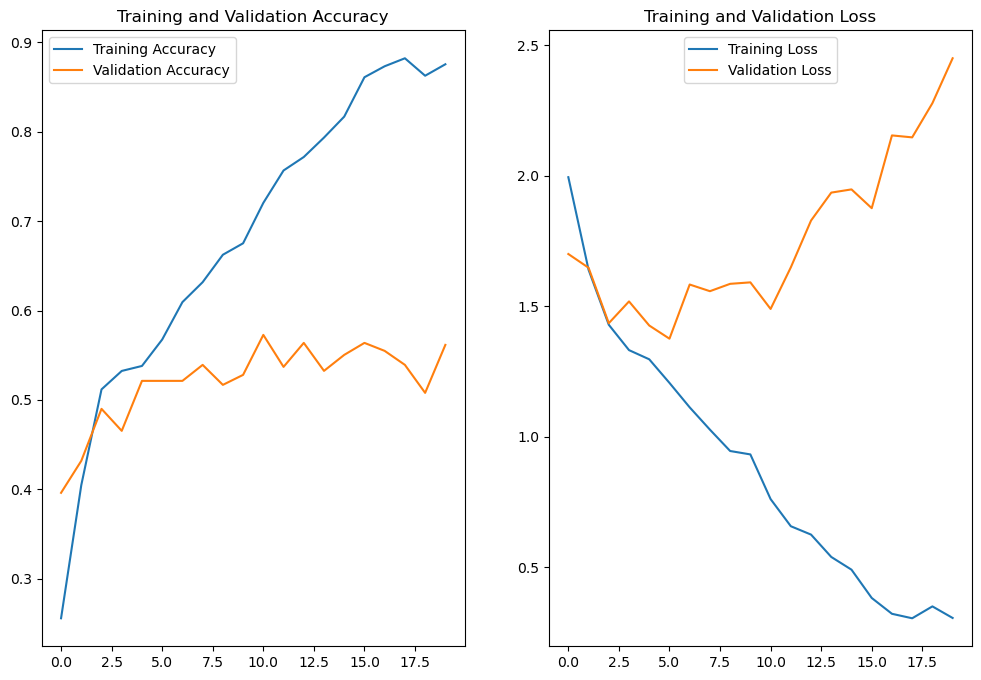

In [17]:
#visualize the training results
visualize_cnn(history, epochs)

### Observations:

Base Model without applyting any normalization :

1. As the number of epochs increase, the training accuracy increases whereas the validation accuracy increases to a max value of 50-55% and then stalls.
2. As the number of epochs increase, the training loss decreases whereas the validation loss decreases in the start but later keeps on increasing.
3. Overall, the validation accuracy was around **50-55%** for the model.
4. The high training accuracy and low validation accuracy tells us that <mark>**the model is Overfitting and needs tuning**</mark>.

### Conclusion: 
Overfitting can happen due to several reasons, such as:

- The training data size is too small and does not contain enough data samples to accurately represent all possible input data values.
- The training data contains large amounts of irrelevant information, also called noisy data.
- The model trains for too long on a single sample set of data.
- The model complexity is high, so it learns the noise within the training data.

For our model, looks like the training data is insufficient. So, let's try to perform some data augmentation strategy to come up with a bigger dataset

Image data augmentation is a technique that can be used to artificially expand the size of a training dataset by creating modified versions of images in the dataset.

In [18]:
#Performing data augmentation on the training dataset
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

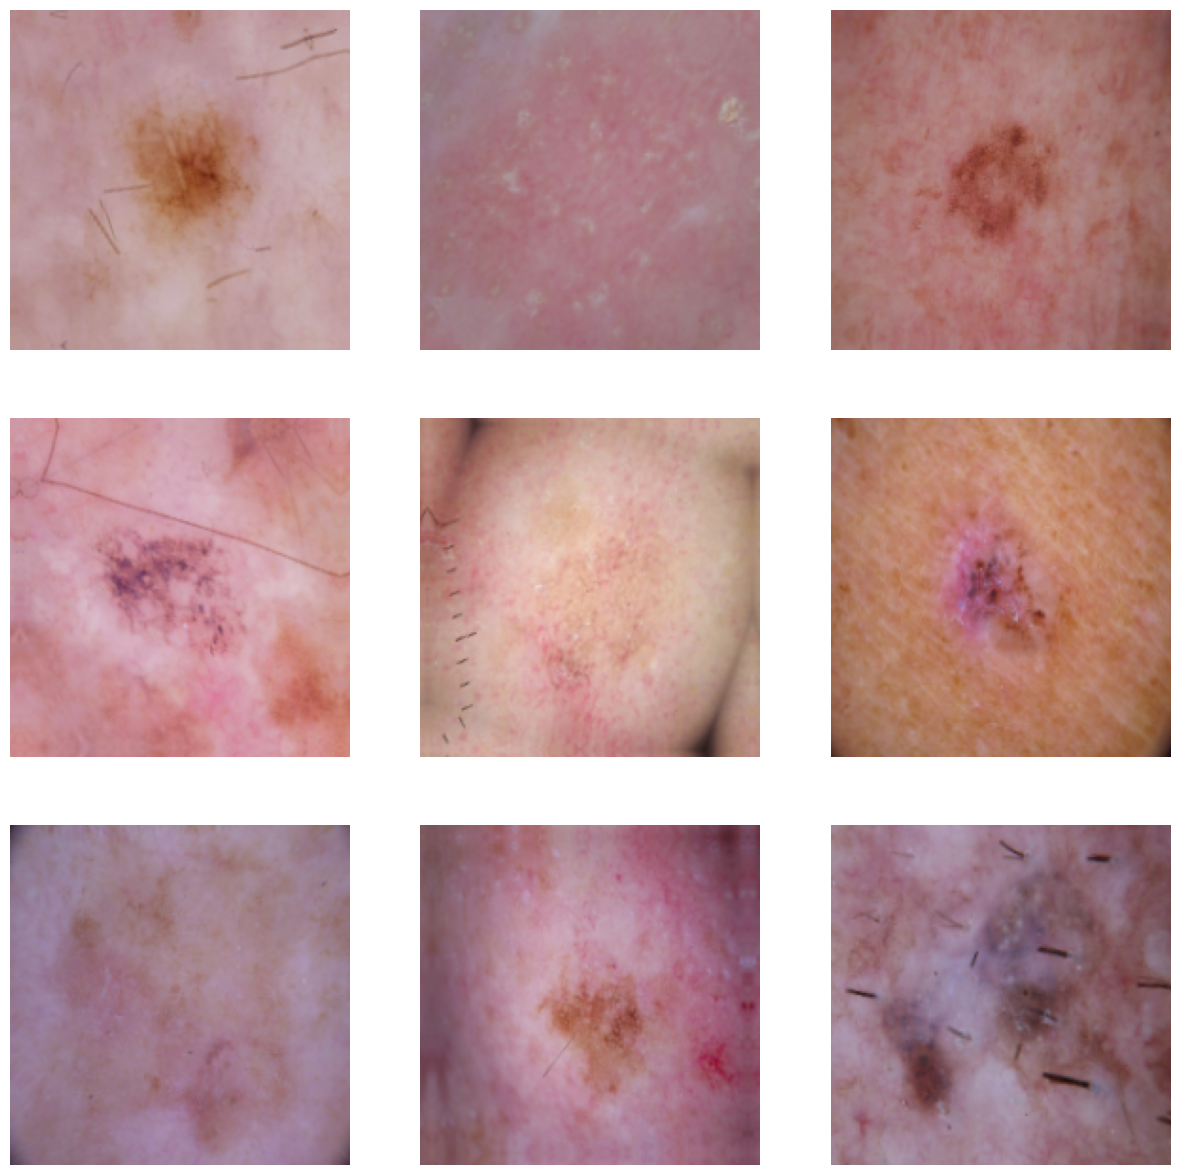

In [19]:
# visualizing the augmentation strategy for one instance of a training image.
plt.figure(figsize=(15, 15))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[i].numpy().astype("uint8"))
        plt.axis("off")

Now, using this augmented data, let's come up with a new model

In [20]:
# CNN Model with data augmentation
model=models.Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(img_height,img_width,3)))

# adding the augmentation layer before the convolution layer
model.add(data_augmentation)

# Convolution layer with 32 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(32,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

model.add(layers.Dense(64,activation='relu'))

model.add(layers.Dense(len(class_names),activation='softmax'))

In [21]:
# Compiling the model without BN
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                  

In [22]:
# Training the model without BN
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 19s 306ms/step - loss: 2.0574 - accuracy: 0.2277 - val_loss: 2.0422 - val_accuracy: 0.1879
Epoch 2/20
56/56 [==============================] - 17s 305ms/step - loss: 1.8579 - accuracy: 0.3365 - val_loss: 1.6664 - val_accuracy: 0.4474
Epoch 3/20
56/56 [==============================] - 17s 303ms/step - loss: 1.6792 - accuracy: 0.4062 - val_loss: 1.5776 - val_accuracy: 0.4564
Epoch 4/20
56/56 [==============================] - 17s 295ms/step - loss: 1.5822 - accuracy: 0.4470 - val_loss: 1.4227 - val_accuracy: 0.5011
Epoch 5/20
56/56 [==============================] - 17s 302ms/step - loss: 1.4603 - accuracy: 0.4771 - val_loss: 1.3894 - val_accuracy: 0.5190
Epoch 6/20
56/56 [==============================] - 17s 303ms/step - loss: 1.4245 - accuracy: 0.5084 - val_loss: 1.3931 - val_accuracy: 0.5078
Epoch 7/20
56/56 [==============================] - 17s 296ms/step - loss: 1.3806 - accuracy: 0.5140 - val_loss: 1.3773 - val_accuracy: 0.5168

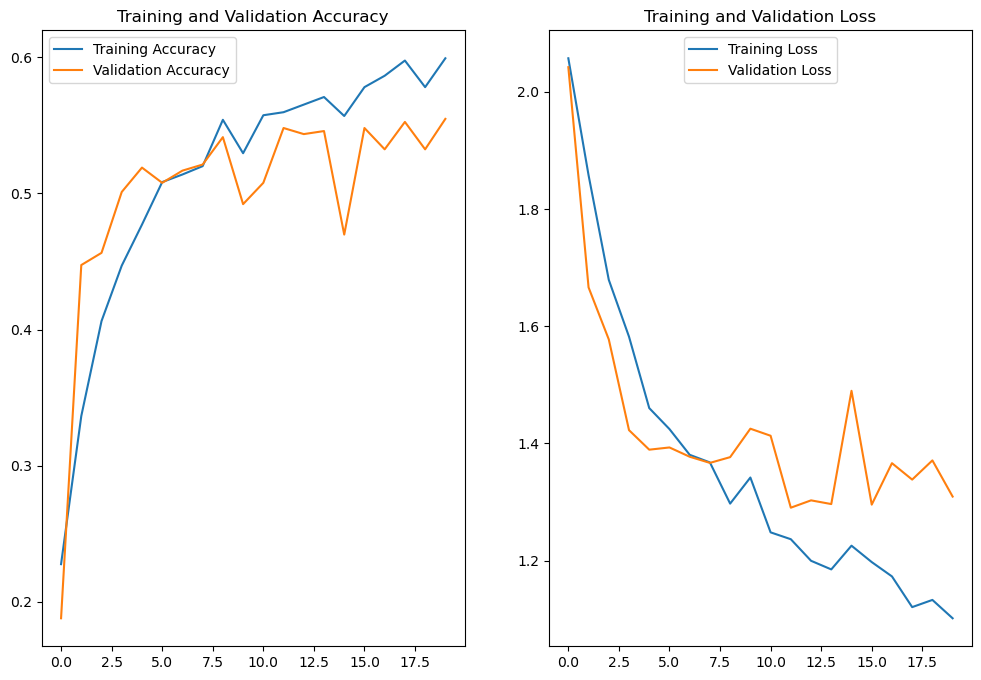

In [23]:
#visualize the results of our model after the data augmentation wiht Dropout layer and without BN
visualize_cnn(history, epochs)

In [24]:
# CNN Model with data augmentation
modelBN=models.Sequential()
# scaling the pixel values from 0-255 to 0-1
modelBN.add(layers.Rescaling(scale=1./255,input_shape=(img_height,img_width,3)))

# adding the augmentation layer before the convolution layer
modelBN.add(data_augmentation)

modelBN.add(BatchNormalization())
# Convolution layer with 32 features, 3x3 filter and relu activation with 2x2 pooling
modelBN.add(layers.Conv2D(32,(3,3),padding = 'same',activation='relu'))
modelBN.add(layers.MaxPooling2D())

modelBN.add(BatchNormalization())
# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
modelBN.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
modelBN.add(layers.MaxPooling2D())

modelBN.add(BatchNormalization())
# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
modelBN.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
modelBN.add(layers.MaxPooling2D())

#Dropout layer with 50% Fraction of the input units to drop.
modelBN.add(layers.Dropout(0.25))

modelBN.add(layers.Flatten())
modelBN.add(layers.Dense(256,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
modelBN.add(layers.Dropout(0.25))

modelBN.add(layers.Dense(len(class_names),activation='softmax'))

In [25]:
# Compiling the model without BN
modelBN.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
modelBN.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 batch_normalization (BatchN  (None, 180, 180, 3)      12        
 ormalization)                                                   
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization_1 (Batc  (None, 90, 90, 32)      

In [26]:
# Training the model with BN
epochs = 20
history = modelBN.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 19s 304ms/step - loss: 5.8660 - accuracy: 0.2812 - val_loss: 2.1709 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 17s 297ms/step - loss: 1.8087 - accuracy: 0.3421 - val_loss: 2.2003 - val_accuracy: 0.1544
Epoch 3/20
56/56 [==============================] - 17s 300ms/step - loss: 1.7687 - accuracy: 0.3689 - val_loss: 2.2391 - val_accuracy: 0.1745
Epoch 4/20
56/56 [==============================] - 17s 298ms/step - loss: 1.6495 - accuracy: 0.4157 - val_loss: 2.4931 - val_accuracy: 0.1499
Epoch 5/20
56/56 [==============================] - 16s 295ms/step - loss: 1.7261 - accuracy: 0.3984 - val_loss: 2.1586 - val_accuracy: 0.2617
Epoch 6/20
56/56 [==============================] - 17s 307ms/step - loss: 1.6651 - accuracy: 0.4163 - val_loss: 1.9866 - val_accuracy: 0.3087
Epoch 7/20
56/56 [==============================] - 17s 296ms/step - loss: 1.5935 - accuracy: 0.4364 - val_loss: 1.8083 - val_accuracy: 0.4027

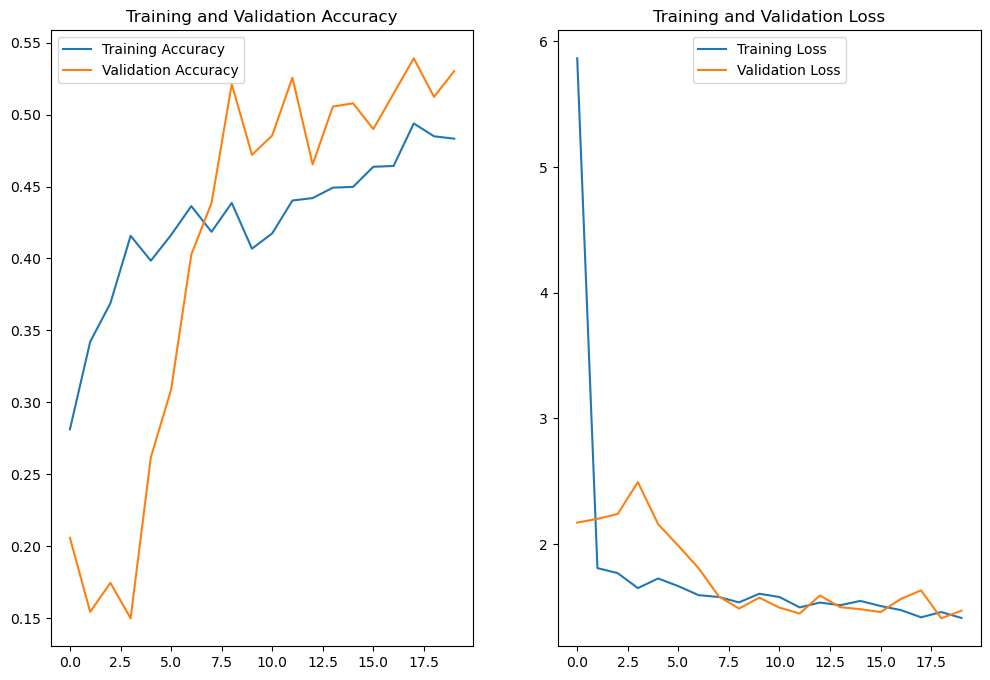

In [27]:
#visualize the results of our model after the data augmentation wiht Dropout layer and with BN
visualize_cnn(history, epochs)

#### Observation

A. Model with dropout 
    
    1. It can be observed that the gap between the training accuracy and the validation accuracy is much less now when compared to the initial model.
    2. The same can be observed with the training loss and the validation loss.
    3. The overall accuracy also looks improved but only by a little.
    4. This implies that the <mark>**overfitting of the model is greatly reduced**</mark> when compared to the initial model but <mark>the overall accuracy isn't really great.</mark>
    
B. Model with dropout and Batch Normalization

    1. Accuracy and loss are comparable with the model with only dropout.
    2. However it doesnot seem stable, as lot of spikes are observed during the training

#### Class Distribution

Let's check the class distribution to see if all the classes(cancer types) are equally distributed

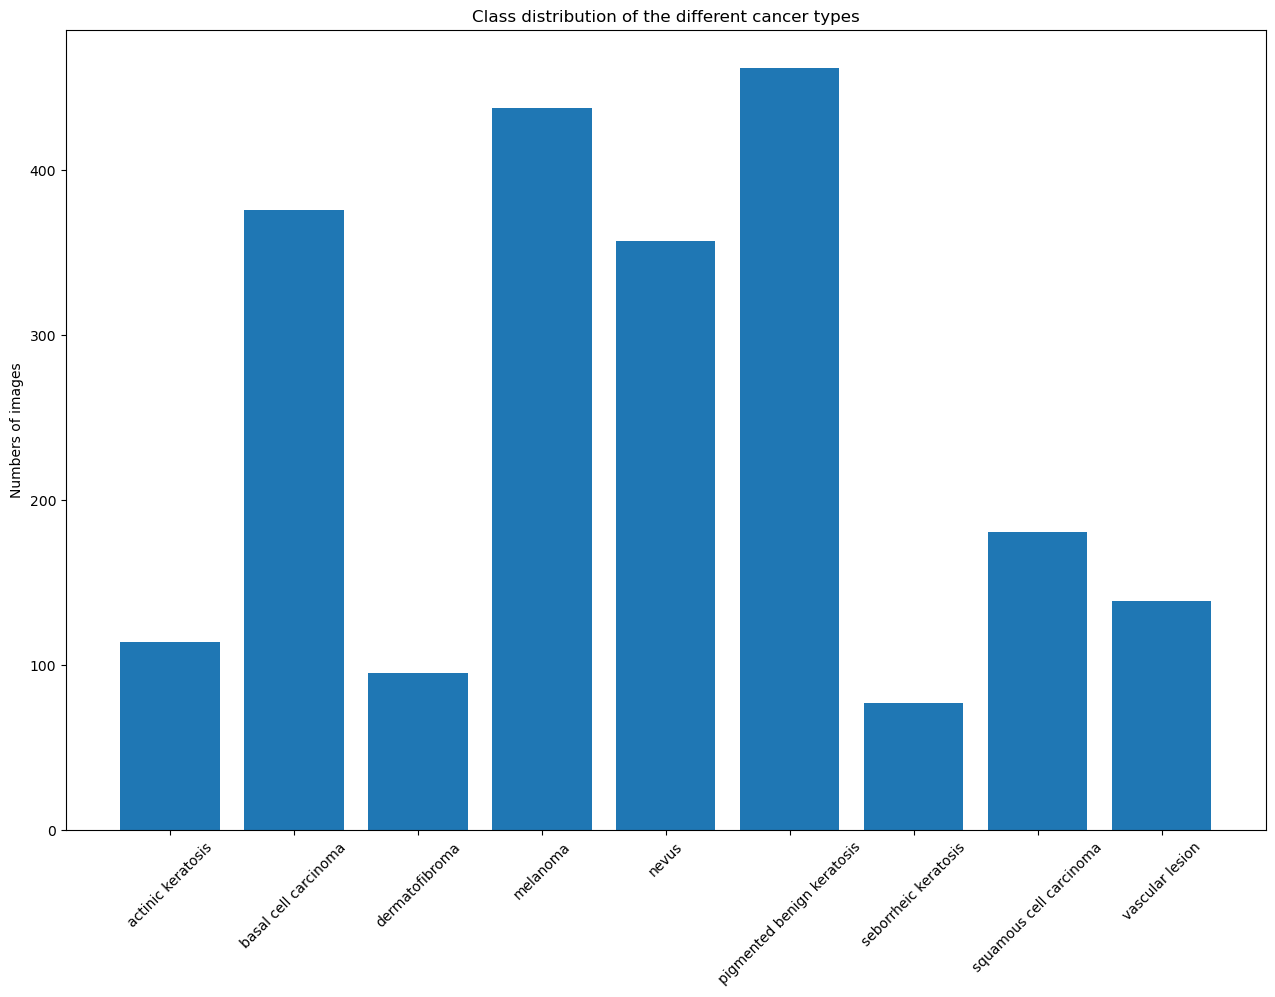

In [28]:
#plot the images to check if all the cancer types are equally distributed
fig = plt.figure(figsize=(12,8))
ax = fig.add_axes([0,0,1,1])
x=[]
y=[]
for i in range(len(class_names)):
    x.append(class_names[i])
    y.append(len(list(data_dir_train.glob(class_names[i]+'/*.jpg'))))

ax.bar(x,y)
ax.set_ylabel('Numbers of images')
ax.set_title('Class distribution of the different cancer types')
plt.xticks(rotation=45)
plt.show()

In [29]:
print("Number of samples for each class: ")
for i in range(len(class_names)):
    print(class_names[i],' - ',len(list(data_dir_train.glob(class_names[i]+'/*.jpg'))))

Number of samples for each class: 
actinic keratosis  -  114
basal cell carcinoma  -  376
dermatofibroma  -  95
melanoma  -  438
nevus  -  357
pigmented benign keratosis  -  462
seborrheic keratosis  -  77
squamous cell carcinoma  -  181
vascular lesion  -  139


#### Observation

1. Class imbalance is observed. It can be seen that some classes have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality.
2. <mark>The class ***seborrheic keratosis*** has the least number of samples with just 77 images.</mark>
3. <mark>The class ***pigmented benign keratosis*** has the highest number of samples with 462 images.</mark>

To rectify this class imbalance, Augmentor library can be used to artificially generate newer samples.

In [48]:
#Install Augmentor
!pip install Augmentor

In [49]:
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [50]:
path_to_training_dataset="D:\\datasets\\MelanomaSkinCancer_ISIC\\augment\\"
# path_to_training_dataset="/content/gdrive/MyDrive/Colab_notebooks/Melanoma_detection/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.set_save_format("auto")
    print("\n Path is ", path_to_training_dataset + i,".")
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)  #Adding 500 samples per class to make sure that none of the classes are sparse

Initialised with 114 image(s) found.
Output directory set to D:\datasets\MelanomaSkinCancer_ISIC\augment\actinic keratosis\output.
 Path is  D:\datasets\MelanomaSkinCancer_ISIC\augment\actinic keratosis .


Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x238FE08BF40>: 100%|█| 500/500 [00:01<00:00, 486.38 Samples


Initialised with 376 image(s) found.
Output directory set to D:\datasets\MelanomaSkinCancer_ISIC\augment\basal cell carcinoma\output.
 Path is  D:\datasets\MelanomaSkinCancer_ISIC\augment\basal cell carcinoma .


Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2388C7DD130>: 100%|█| 500/500 [00:00<00:00, 511.25 Samples


Initialised with 95 image(s) found.
Output directory set to D:\datasets\MelanomaSkinCancer_ISIC\augment\dermatofibroma\output.
 Path is  D:\datasets\MelanomaSkinCancer_ISIC\augment\dermatofibroma .


Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2388C7F5370>: 100%|█| 500/500 [00:01<00:00, 494.07 Samples


Initialised with 438 image(s) found.
Output directory set to D:\datasets\MelanomaSkinCancer_ISIC\augment\melanoma\output.
 Path is  D:\datasets\MelanomaSkinCancer_ISIC\augment\melanoma .


Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x232A367D340>: 100%|█| 500/500 [00:02<00:00, 176.68 Samples


Initialised with 357 image(s) found.
Output directory set to D:\datasets\MelanomaSkinCancer_ISIC\augment\nevus\output.
 Path is  D:\datasets\MelanomaSkinCancer_ISIC\augment\nevus .


Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x232AC931040>: 100%|█| 500/500 [00:03<00:00, 156.05 Samples


Initialised with 462 image(s) found.
Output directory set to D:\datasets\MelanomaSkinCancer_ISIC\augment\pigmented benign keratosis\output.
 Path is  D:\datasets\MelanomaSkinCancer_ISIC\augment\pigmented benign keratosis .


Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2387AC99850>: 100%|█| 500/500 [00:01<00:00, 493.10 Samples


Initialised with 77 image(s) found.
Output directory set to D:\datasets\MelanomaSkinCancer_ISIC\augment\seborrheic keratosis\output.
 Path is  D:\datasets\MelanomaSkinCancer_ISIC\augment\seborrheic keratosis .


Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x238786A3CA0>: 100%|█| 500/500 [00:01<00:00, 332.89 Sample


Initialised with 181 image(s) found.
Output directory set to D:\datasets\MelanomaSkinCancer_ISIC\augment\squamous cell carcinoma\output.
 Path is  D:\datasets\MelanomaSkinCancer_ISIC\augment\squamous cell carcinoma .


Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2390F483BE0>: 100%|█| 500/500 [00:01<00:00, 462.11 Samples


Initialised with 139 image(s) found.
Output directory set to D:\datasets\MelanomaSkinCancer_ISIC\augment\vascular lesion\output.
 Path is  D:\datasets\MelanomaSkinCancer_ISIC\augment\vascular lesion .


Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2387ACA24C0>: 100%|█| 500/500 [00:01<00:00, 468.15 Samples


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [51]:
data_dir_train = pathlib.Path('D:\\datasets\\MelanomaSkinCancer_ISIC\\augment\\')
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print("Newly generated images with the Augmentor library:", image_count_train)

Newly generated images with the Augmentor library: 4500


Lets see the distribution of augmented data after adding new images to the original training data.

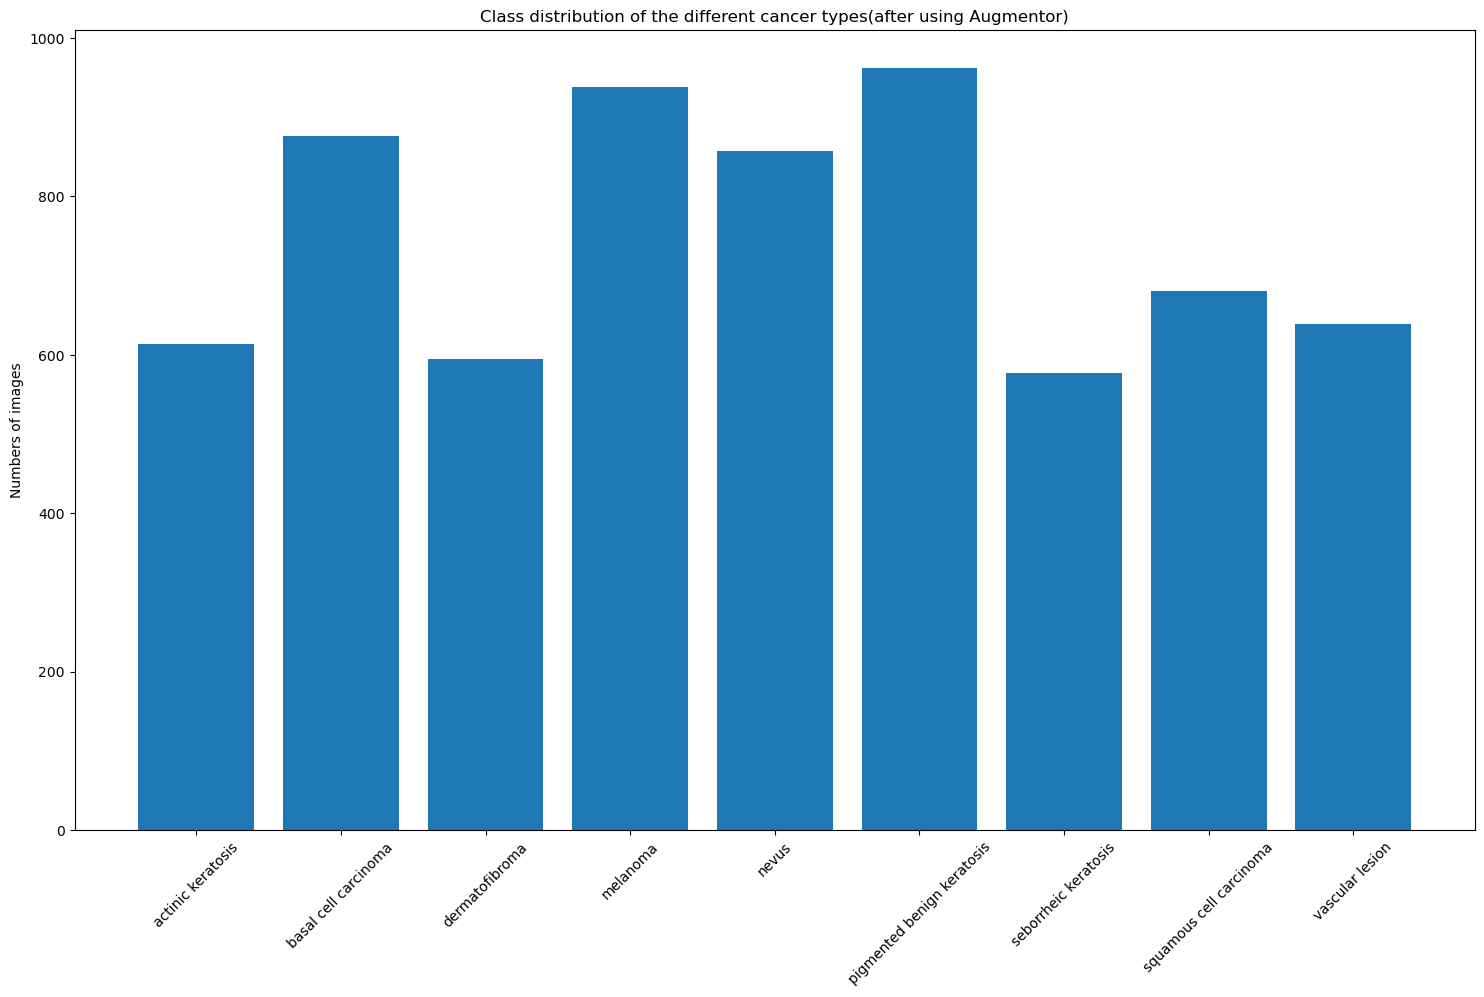

In [52]:
#plot the images to check if all the cancer types are equally distributed
fig = plt.figure(figsize=(14,8))
ax = fig.add_axes([0,0,1,1])
x=[]
y=[]
for i in range(len(class_names)):
    x.append(class_names[i])
    y.append(len(list(data_dir_train.glob(class_names[i]+'/*.jpg'))) + len(list(data_dir_train.glob(class_names[i]+'/output/*.jpg'))))

ax.bar(x,y)
ax.set_ylabel('Numbers of images')
ax.set_title('Class distribution of the different cancer types(after using Augmentor)')
plt.xticks(rotation=45)
plt.show()

#### Observation:

We have added 500 images to all the classes to maintain some class balance. Thus, now there are enough samples to analyze our model.

Let's create a training and validation dataset with our new samples

In [53]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=seed_val,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [54]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=seed_val,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [55]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Train the model on the data created using Augmentor

In [92]:
# CNN Model on the data created using Augmentor
model=models.Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(img_height,img_width,3)))

# Convolution layer with 32 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(32,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#model.add(layers.Dense(128,activation='relu'))

model.add(layers.Dense(64,activation='relu'))

model.add(layers.Dense(len(class_names),activation='softmax'))

In [93]:
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_14 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_42 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_42 (MaxPoolin  (None, 90, 90, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_43 (Conv2D)          (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_43 (MaxPoolin  (None, 45, 45, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_44 (Conv2D)          (None, 45, 45, 128)     

In [94]:
# Training the model
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 3s 14ms/step - loss: 2.0142 - accuracy: 0.2213 - val_loss: 1.7160 - val_accuracy: 0.3593
Epoch 2/30
169/169 [==============================] - 2s 13ms/step - loss: 1.5990 - accuracy: 0.3722 - val_loss: 1.4666 - val_accuracy: 0.4380
Epoch 3/30
169/169 [==============================] - 2s 13ms/step - loss: 1.4521 - accuracy: 0.4407 - val_loss: 1.3708 - val_accuracy: 0.4781
Epoch 4/30
169/169 [==============================] - 2s 13ms/step - loss: 1.3591 - accuracy: 0.4846 - val_loss: 1.2721 - val_accuracy: 0.5212
Epoch 5/30
169/169 [==============================] - 2s 13ms/step - loss: 1.2158 - accuracy: 0.5469 - val_loss: 1.1206 - val_accuracy: 0.5761
Epoch 6/30
169/169 [==============================] - 2s 13ms/step - loss: 1.1217 - accuracy: 0.5855 - val_loss: 1.0735 - val_accuracy: 0.6192
Epoch 7/30
169/169 [==============================] - 2s 13ms/step - loss: 0.9933 - accuracy: 0.6343 - val_loss: 0.9932 - val_accuracy: 0.6385

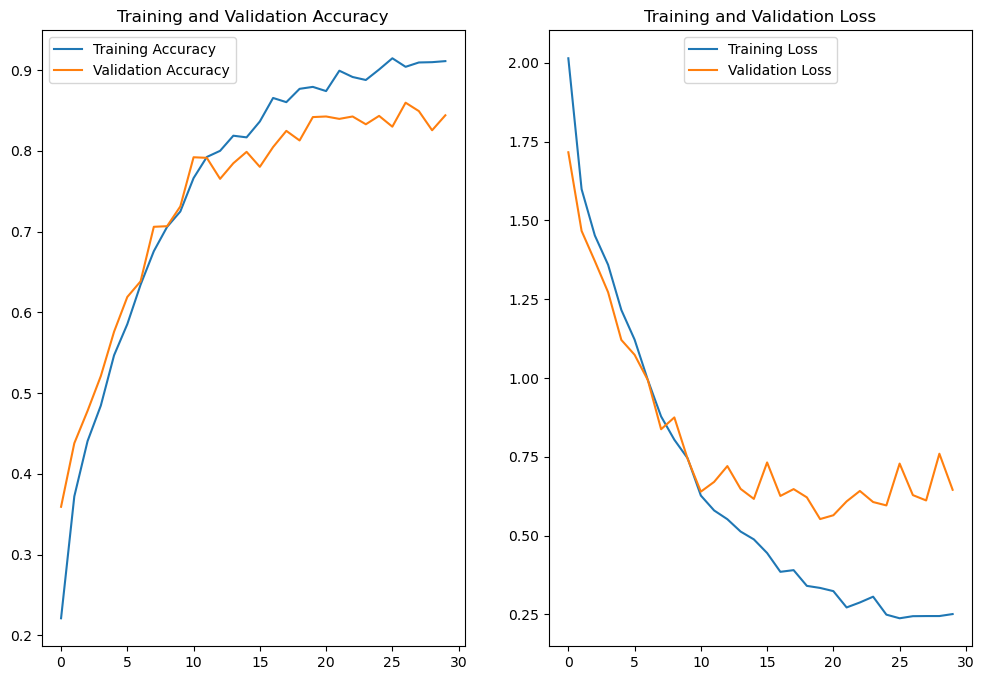

In [95]:
#visualize the results of model wiht Dropout layer and without BN
visualize_cnn(history, epochs)

In [80]:
# CNN Model on the data created using Augmentor
modelBN=models.Sequential()
# scaling the pixel values from 0-255 to 0-1
modelBN.add(layers.Rescaling(scale=1./255,input_shape=(img_height,img_width,3)))

modelBN.add(BatchNormalization())
# Convolution layer with 32 features, 3x3 filter and relu activation with 2x2 pooling
modelBN.add(layers.Conv2D(32,(3,3),padding = 'same',activation='relu'))
modelBN.add(layers.MaxPooling2D())

modelBN.add(BatchNormalization())
# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
modelBN.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
modelBN.add(layers.MaxPooling2D())

modelBN.add(BatchNormalization())
# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
modelBN.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
modelBN.add(layers.MaxPooling2D())

#Dropout layer with 50% Fraction of the input units to drop.
modelBN.add(layers.Dropout(0.5))

modelBN.add(layers.Flatten())
modelBN.add(layers.Dense(256,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
modelBN.add(layers.Dropout(0.25))

modelBN.add(layers.Dense(128,activation='relu'))

#modelBN.add(layers.Dense(64,activation='relu'))

modelBN.add(layers.Dense(len(class_names),activation='softmax'))


In [81]:
# Compiling the model
modelBN.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
modelBN.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_11 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 batch_normalization_9 (Batc  (None, 180, 180, 3)      12        
 hNormalization)                                                 
                                                                 
 conv2d_33 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 90, 90, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization_10 (Bat  (None, 90, 90, 32)       128       
 chNormalization)                                                
                                                     

In [82]:
# Training the model
epochs = 30
history = modelBN.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 4s 19ms/step - loss: 2.9009 - accuracy: 0.2971 - val_loss: 2.5551 - val_accuracy: 0.1099
Epoch 2/30
169/169 [==============================] - 3s 18ms/step - loss: 1.6810 - accuracy: 0.3533 - val_loss: 1.9657 - val_accuracy: 0.2428
Epoch 3/30
169/169 [==============================] - 3s 18ms/step - loss: 1.6369 - accuracy: 0.3778 - val_loss: 1.4472 - val_accuracy: 0.4484
Epoch 4/30
169/169 [==============================] - 3s 18ms/step - loss: 1.5684 - accuracy: 0.3932 - val_loss: 1.4122 - val_accuracy: 0.4647
Epoch 5/30
169/169 [==============================] - 3s 18ms/step - loss: 1.5177 - accuracy: 0.4169 - val_loss: 1.4063 - val_accuracy: 0.4410
Epoch 6/30
169/169 [==============================] - 3s 18ms/step - loss: 1.4992 - accuracy: 0.4284 - val_loss: 1.4058 - val_accuracy: 0.4892
Epoch 7/30
169/169 [==============================] - 3s 18ms/step - loss: 1.3732 - accuracy: 0.4612 - val_loss: 1.1965 - val_accuracy: 0.5197

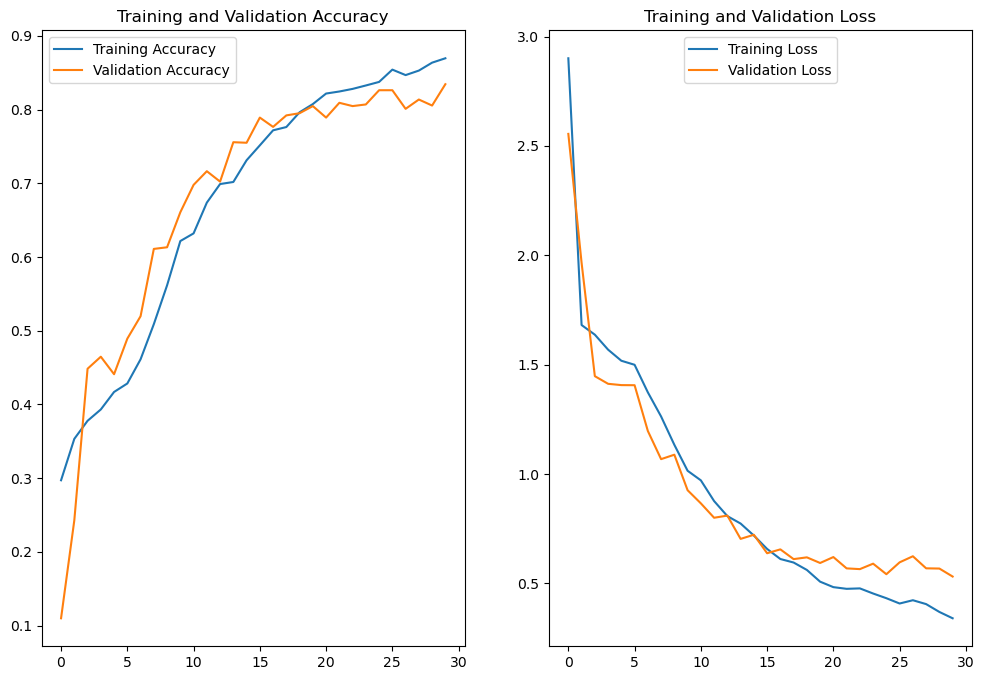

In [83]:
#visualize the results of model wiht Dropout layer and with BN
visualize_cnn(history, epochs)

### Observations

A. For model with dropout layer

    1. Accuracy : 
        a. model has achieved ~84% accuracy on the validation set. 
        b. the training accuracy as well as the validation accuracy increases.
        
    2. Loss : 
        a. model has achieved 0.64 loss on the validations dataset
        b. training and validation loss also decreases over epochs.
        
    3. Overfitting/Underfitting : 
            a.  It generalizes better than the earlier modeld, still we see some overfitting. 
            b. Gap between the training and validation datasets over both 'Accuracy' and 'loss' is less.  
                 

B. For model with dropout & Batch Normalization layer
    1. Accuracy & Loss : 
                comparable with the model having only dropout layer, 
    
    2. This model generalizes well. validation accuracy closer to the training accuracy at higer epochs [better than the above model.]
    

To conclude, <mark>**Class rebalancing improved the overall accuracy and also reduced the overall loss**.</mark>